In [1]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

ModuleNotFoundError: No module named 'transformers'

In [2]:
def read_data(input_folder, labels_folder=None):
    # This is slightly different version of your make_dataframe()
    # instead of making a dataframe it returns two lists,
    # one with texts the other one with corresponding labels.
    # Using a dict initially is just a safeguard for making sure
    # text/label matches even if they are not sorted correctly.
    text, label = dict(), dict()    
    for fname in os.listdir(input_folder):
        tid = fname.replace('article', '').replace('.txt', '')
        with open(os.path.join(input_folder, fname), 'r') as f:
            text[tid] = f.read().strip()   
    if labels_folder:
        with open(labels_folder, 'rt') as f:
            for line in f:
                lid, l = line.strip().split()
                label[lid] = l    
        assert set(label.keys()) == set(text.keys())
    if label:
        return [text[k] for k in text], [label[k] for k in text]
    else:
        return [text[k] for k in text]

In [3]:
train_txt, train_lab = read_data('Data/data/en/train-articles-subtask-1/', 'Data/data/en/train-labels-subtask-1.txt')

(108, 7571, 908.6120092378753, 0.6628175519630485)

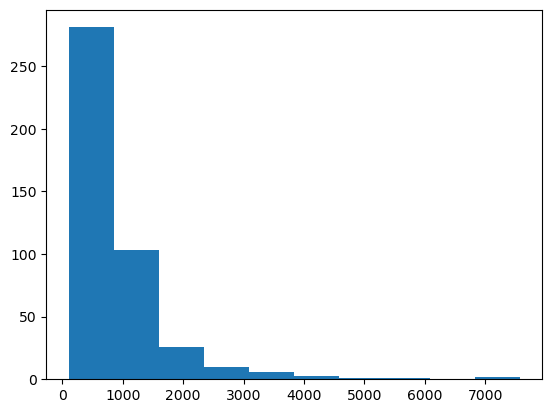

In [4]:
lendist = [len(s.split()) for s in train_txt]
_ = plt.hist(lendist)
min(lendist), max(lendist), sum(lendist)/len(lendist), sum([l > 512 for l in lendist])/len(lendist)
# What this shows is that most of your texts are rather long.
# Not a problem for traditional models with sparse features,
# but use of tokenizers from bert-like models may make things complicated.


In [5]:
# I had difficulties understanding how you obtained the tokenizer.
# You seem to have a complex expression bringing both the tokenizer
# and the model itself. We only need the tokenizer.
# So the following only gets a tokenizer from HuggingFace hub.
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [6]:
# The few cells below is to show what is happening with the tokenizer.
# This is how to tokenize a single text.
tokenizer(train_txt[0])

{'input_ids': [101, 5893, 13824, 8010, 1107, 12014, 1180, 1129, 112, 5992, 112, 131, 23750, 9571, 118, 1109, 1291, 3225, 14213, 2705, 1113, 9031, 1163, 170, 10310, 13824, 18162, 1691, 1106, 1138, 1151, 1814, 1223, 1654, 1107, 12014, 117, 1133, 6926, 1103, 1397, 8010, 1156, 2620, 1129, 5992, 119, 107, 1109, 1397, 6580, 1180, 1129, 1167, 8481, 1137, 5992, 117, 107, 23750, 2524, 118, 1615, 6564, 5864, 24930, 3822, 4165, 144, 4638, 9730, 25014, 1361, 1500, 13509, 1107, 9571, 117, 25504, 1115, 107, 1103, 2486, 1110, 3021, 119, 107, 1760, 8010, 1104, 1241, 171, 10354, 13207, 13824, 117, 1134, 1110, 2819, 1118, 10594, 13475, 2258, 22593, 4490, 17905, 117, 1105, 185, 1673, 1818, 13207, 13824, 117, 2819, 1825, 1106, 1825, 117, 1144, 1841, 1167, 1190, 2363, 1234, 1107, 1103, 1890, 4879, 2248, 3790, 1290, 1360, 119, 12014, 1144, 3421, 171, 10354, 13207, 13824, 8010, 1116, 1593, 1451, 1214, 1290, 2253, 117, 1510, 2416, 1118, 13475, 14979, 3304, 8966, 119, 1109, 3653, 12246, 1106, 1294, 170, 14019,

In [7]:
# We can use the token ids above (with some care),
# but we can also get the actual texts of the tokens.
tok = tokenizer(train_txt[0])
tokenizer.convert_ids_to_tokens(tok.input_ids)

['[CLS]',
 'Next',
 'plague',
 'outbreak',
 'in',
 'Madagascar',
 'could',
 'be',
 "'",
 'stronger',
 "'",
 ':',
 'WHO',
 'Geneva',
 '-',
 'The',
 'World',
 'Health',
 'Organisation',
 'chief',
 'on',
 'Wednesday',
 'said',
 'a',
 'deadly',
 'plague',
 'epidemic',
 'appeared',
 'to',
 'have',
 'been',
 'brought',
 'under',
 'control',
 'in',
 'Madagascar',
 ',',
 'but',
 'warned',
 'the',
 'next',
 'outbreak',
 'would',
 'likely',
 'be',
 'stronger',
 '.',
 '"',
 'The',
 'next',
 'transmission',
 'could',
 'be',
 'more',
 'pronounced',
 'or',
 'stronger',
 ',',
 '"',
 'WHO',
 'Director',
 '-',
 'General',
 'Ted',
 '##ros',
 'Ad',
 '##han',
 '##om',
 'G',
 '##he',
 '##bre',
 '##yes',
 '##us',
 'told',
 'reporters',
 'in',
 'Geneva',
 ',',
 'insisting',
 'that',
 '"',
 'the',
 'issue',
 'is',
 'serious',
 '.',
 '"',
 'An',
 'outbreak',
 'of',
 'both',
 'b',
 '##ub',
 '##onic',
 'plague',
 ',',
 'which',
 'is',
 'spread',
 'by',
 'infected',
 'rats',
 'via',
 'fl',
 '##ea',
 'bites',
 ','

In [8]:
# Now we can do this for real.
# The following is similar to calling the tokenizer,
# but tokenizes all the texts in batch - generally faster.
# It will warn, but we will not use it with BERT, so no worries.
train_tokenized = tokenizer.batch_encode_plus(train_txt, truncation=False, padding=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors


In [10]:
train_tokens = [tokenizer.convert_ids_to_tokens(x) for x in train_tokenized.input_ids]
# Now we have a list of lists with each member a string token.

(150, 10648, 1219.027713625866, 0.8244803695150116)

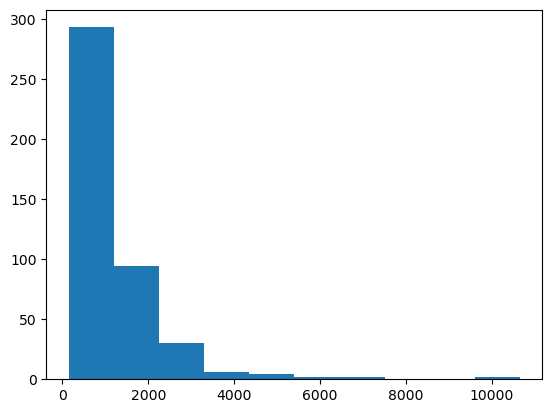

In [15]:
lendist = [len(x) for x in train_tokens]
_ = plt.hist(lendist)
min(lendist), max(lendist), sum(lendist)/len(lendist), sum([l > 512 for l in lendist])/len(lendist)
# We now have even longer sequences - 80% of the documents would be truncated if we feed them
# to a pretrained model with sequence length of 512 tokens.

In [11]:
# now, we can vectorize this with sklearn,
# However, we want to skip any tokenization/processing
# by the sklearn tokenizers.
# Note that this only does singl-token features.
# If we want token n-grams, we need to either pre-process our input token list,
# or pass an analyzer that returns n-gram features.
vec = TfidfVectorizer(analyzer=lambda x: x)
train_X = vec.fit_transform(train_tokens)

In [12]:
# Now we can use any sklearn classifier, or set up a pipleline as you did
# I'll be lazy here.
clf = LogisticRegression()
clf.fit(train_X, train_lab)

LogisticRegression()

In [13]:
# Now, convert the development set before the same way:
dev_txt = read_data('Data/data/en/dev-articles-subtask-1/')
dev_tokenized = tokenizer.batch_encode_plus(dev_txt, truncation=False, padding=False)
dev_tokens = [tokenizer.convert_ids_to_tokens(x) for x in dev_tokenized.input_ids]
dev_X = vec.transform(dev_tokens)

In [14]:
pred = clf.predict(dev_X)
pred
# Not great results without further experimentation,
# but conceptually this should be help.

array(['opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'reporting', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion'

In [60]:
# Bonus: using  subword-token ngrams
# the following function returns n-gram ranges of a given sequence.
def get_ngrams(s, ngmin, ngmax, separator="-", suffix="", flatten=True):
    """ For the given sequence s. Return all ngrams in range ngmin-ngmax.
        spearator is useful for readability
        suffix is an arbitrary string useful for distinguishing
                in case differernt types of ngrams
        if flatten is false, a list of lists is returned where the
                first element contains the ngrams of size ngmin
                and the last contains the ngrams of size ngmax
    """

    # return a single dummy feature if there are no applicable ngrams
    # probably resulting in a mojority-class classifier
    if ngmax == 0 or (ngmax - ngmin < 0) :
        return ['__dummy__']

    ngrams = [[] for x in range(1, ngmax + 1)]
    for i, ch in enumerate(s):
        for ngsize in range(ngmin, ngmax + 1):
            if (i + ngsize) <= len(s):
                ngrams[ngsize - 1].append(
                        separator.join(s[i:i+ngsize]) + suffix)
    if flatten:
        ngrams = [ng for nglist in ngrams for ng in nglist]
    return ngrams
# example usage
get_ngrams(['a', 'b', 'c', 'd'], 1, 3)

['a', 'b', 'c', 'd', 'a-b', 'b-c', 'c-d', 'a-b-c', 'b-c-d']

In [63]:
# now we can vectorize using this 'analyzer'
vec = TfidfVectorizer(analyzer=lambda x: get_ngrams(x, 1, 3))
train_X = vec.fit_transform(train_tokens)

In [65]:
# train the model again - if tuned well,
# this should work better since it has more information.
clf = LogisticRegression(C=5.0)
clf.fit(train_X, train_lab)
# re-vectorize the devset
dev_X = vec.transform(dev_tokens)
# predict
clf.predict(dev_X)

array(['opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'reporting', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'opinion', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'reporting', 'opinion', 'opinion', 'opinion',
       'opinion', 'opinion', 'reporting', 'opin